# The food vision 101 project

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2024 <br>

Thi project is about to rival the CNN model that was build and publiced by the authors of the paper <b>[DeepFood: Deep Learning-Based Food Image Recognition for Computer-Aided Dietary Assessment 2016](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)</b>. The paper addresses the challenge of accurately documenting dietary caloric intake, which is crucial for managing weight loss and understanding dietary habits. Traditional methods for dietary assessment, such as 24-hour recalls and food frequency questionnaires, rely on an individual's memory, which can introduce bias and inaccuracies. To overcome these limitations, the paper proposes a computer-aided technical solution using deep learning-based food image recognition algorithms. <b>The core innovation of the paper is the development of a new Convolutional Neural Network (CNN)-based algorithm for food image recognition with the highest score reaching 77,4%</b>.

So our goal is to create a CNN that reach or surpass this score in the same dataset <b>(Food-101)</b>.

|  | 🍔🍝 About the Bataset 🥪🥞 |
|-----|-----|
| Dataset source | TensorFlow Datasets | 
| Train data | 75,750 images | 
| Test data | 25,250 images | 
| Mixed precision | Yes |
| Data loading | Performanant tf.data API |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 

## Load libraries

In [1]:
# Helper Functions
from helper_functions import plot_loss_accuracy_curves, random_img_show, walk_through_dir, preprocess_img

# Data manipulation
import pandas as pd
import numpy as np

# Modeling and Mixed percision training
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

2024-03-06 22:44:27.776061: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 22:44:27.801704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 22:44:27.801772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 22:44:27.803494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 22:44:27.813564: I tensorflow/core/platform/cpu_feature_guar

## Data Exploration

> Access the data images from the tensorflow datasets

In [2]:
# Load in the data (this wi ll take some time..)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True,
                                             data_dir='Dataset/'
                                            )

2024-03-06 22:44:28.949352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 22:44:29.241572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 22:44:29.241609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 22:44:29.253210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 22:44:29.253245: I external/local_xla/xla/stream_executor

> A directory walk throught that we can see each directory and the number of images inside

In [3]:
walk_through_dir('Dataset/')

There are 2 directories and 0 images in 'Dataset/'.
There are 1 directories and 2 images in 'Dataset/downloads'.
There are 1 directories and 0 images in 'Dataset/downloads/extracted'.
There are 1 directories and 0 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz'.
There are 2 directories and 2 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101'.
There are 101 directories and 0 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images'.
There are 0 directories and 1000 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images/apple_pie'.
There are 0 directories and 1000 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cv

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

> Class labels presentation

In [5]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
print(len(class_names))

101


> Plot random images

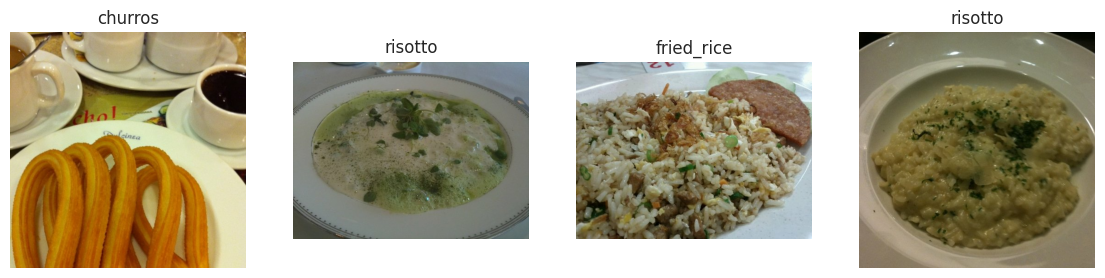

In [7]:
random_img_show(train_data, class_names)

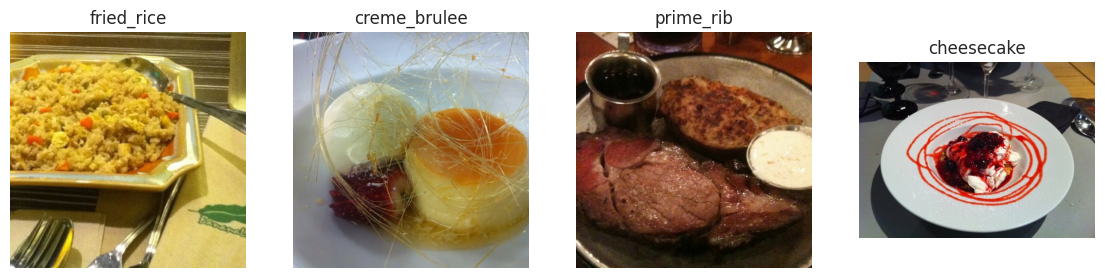

In [8]:
random_img_show(test_data, class_names)

> The images in both train and test dataset have no standar shape

In [9]:
# Output info about our training sample
for image, label in train_data.take(2):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 77
  Class name (str form): pork_chop
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 11
  Class name (str form): caesar_salad
        


In [10]:
# Output info about our training sample
for image, label in test_data.take(2):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 28
  Class name (str form): croque_madame
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 12
  Class name (str form): cannoli
        


> Shape variance in both train and test datasets

In [11]:
train_shape_variance = set()

for image, label in train_data:
    train_shape_variance.add(image.shape)
    
train_shape_variance

{TensorShape([122, 512, 3]),
 TensorShape([140, 512, 3]),
 TensorShape([165, 512, 3]),
 TensorShape([181, 512, 3]),
 TensorShape([182, 512, 3]),
 TensorShape([188, 512, 3]),
 TensorShape([210, 512, 3]),
 TensorShape([218, 512, 3]),
 TensorShape([220, 512, 3]),
 TensorShape([222, 512, 3]),
 TensorShape([225, 512, 3]),
 TensorShape([226, 512, 3]),
 TensorShape([228, 512, 3]),
 TensorShape([229, 512, 3]),
 TensorShape([230, 512, 3]),
 TensorShape([231, 512, 3]),
 TensorShape([232, 512, 3]),
 TensorShape([236, 512, 3]),
 TensorShape([239, 512, 3]),
 TensorShape([241, 512, 3]),
 TensorShape([243, 512, 3]),
 TensorShape([246, 512, 3]),
 TensorShape([247, 512, 3]),
 TensorShape([249, 512, 3]),
 TensorShape([252, 512, 3]),
 TensorShape([253, 512, 3]),
 TensorShape([254, 512, 3]),
 TensorShape([256, 512, 3]),
 TensorShape([257, 512, 3]),
 TensorShape([259, 512, 3]),
 TensorShape([262, 512, 3]),
 TensorShape([265, 512, 3]),
 TensorShape([266, 512, 3]),
 TensorShape([267, 512, 3]),
 TensorShape([

In [12]:
len(train_shape_variance)

448

In [13]:
test_shape_variance = set()

for image, label in test_data:
    test_shape_variance.add(image.shape)

test_shape_variance

{TensorShape([213, 512, 3]),
 TensorShape([226, 512, 3]),
 TensorShape([254, 512, 3]),
 TensorShape([256, 512, 3]),
 TensorShape([260, 512, 3]),
 TensorShape([262, 512, 3]),
 TensorShape([268, 512, 3]),
 TensorShape([271, 512, 3]),
 TensorShape([272, 512, 3]),
 TensorShape([276, 512, 3]),
 TensorShape([281, 512, 3]),
 TensorShape([282, 512, 3]),
 TensorShape([287, 512, 3]),
 TensorShape([288, 512, 3]),
 TensorShape([289, 512, 3]),
 TensorShape([290, 512, 3]),
 TensorShape([291, 512, 3]),
 TensorShape([293, 512, 3]),
 TensorShape([294, 512, 3]),
 TensorShape([295, 512, 3]),
 TensorShape([298, 512, 3]),
 TensorShape([299, 512, 3]),
 TensorShape([301, 512, 3]),
 TensorShape([304, 512, 3]),
 TensorShape([305, 512, 3]),
 TensorShape([306, 512, 3]),
 TensorShape([307, 512, 3]),
 TensorShape([308, 512, 3]),
 TensorShape([309, 512, 3]),
 TensorShape([310, 512, 3]),
 TensorShape([312, 512, 3]),
 TensorShape([313, 512, 3]),
 TensorShape([314, 512, 3]),
 TensorShape([316, 512, 3]),
 TensorShape([

In [14]:
len(test_shape_variance)

302

> Images will also need normalization

In [15]:
for image, label in train_data.take(1):
    print(image.numpy())

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  81 102]
  [142  78 102]
  [139  75  99]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [159  96 115]
  [154  89 111]
  [146  83 104]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [162  98 114]
  [162  95 113]
  [157  93 110]]

 ...

 [[ 75  32  16]
  [ 77  34  17]
  [ 78  35  19]
  ...
  [ 99  31  20]
  [104  32  20]
  [106  34  20]]

 [[ 81  34  18]
  [ 81  34  16]
  [ 82  35  19]
  ...
  [102  33  26]
  [104  36  27]
  [109  39  31]]

 [[ 79  30  13]
  [ 80  31  14]
  [ 81  32  15]
  ...
  [113  46  40]
  [118  49  42]
  [125  56  49]]]


In [16]:
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(0, 255)

## Data Preparation

> In order to process tha images efficiently and train the model the faster that we can, we will need to modify the images and the way that the images are processed by the gpu and cpu. So, we will create batches of the images and enable the multitasking of the computer in order to load batches of images and augment them, while the gpu is training the model with the previous batch of images.

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

> Lets also create callback functions that will save our models progress and to early stop our models training if the model doesn't learn anything in a amount of epochs.

In [19]:
# Initialize the path that will save the model
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension

# Create ModelCheckpoint callback to save model's progress
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [20]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5) # if val loss decreases for 5 epochs in a row, stop training

## Modeling

> The modeling is beeing performed in a Geforce RTX 3060 with 12.4 score of computational capabilities. This gpu enables the mixed percision training and the model will train and perform faster than without mixed percision.

In [21]:
!nvidia-smi

Wed Mar  6 22:44:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             13W /  170W |   11355MiB /  12288MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-03-06 22:44:48.689058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

> As for the modeling we will used already trained model in the image recognition cause we don't have the resources and the time to create from scratch a model capable to outperforme the model of the paper. So with the help of transfer learning we will take existing models and fine tune them in our situation.

In [25]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

In [26]:
print(f'Number of layers: {len(base_model.layers)}')
for number, layer in enumerate(base_model.layers):
    print(f'{number} Layer name: {layer.name}')


Number of layers: 270
0 Layer name: input_1
1 Layer name: rescaling
2 Layer name: normalization
3 Layer name: stem_conv
4 Layer name: stem_bn
5 Layer name: stem_activation
6 Layer name: block1a_project_conv
7 Layer name: block1a_project_bn
8 Layer name: block1a_project_activation
9 Layer name: block2a_expand_conv
10 Layer name: block2a_expand_bn
11 Layer name: block2a_expand_activation
12 Layer name: block2a_project_conv
13 Layer name: block2a_project_bn
14 Layer name: block2b_expand_conv
15 Layer name: block2b_expand_bn
16 Layer name: block2b_expand_activation
17 Layer name: block2b_project_conv
18 Layer name: block2b_project_bn
19 Layer name: block2b_drop
20 Layer name: block2b_add
21 Layer name: block3a_expand_conv
22 Layer name: block3a_expand_bn
23 Layer name: block3a_expand_activation
24 Layer name: block3a_project_conv
25 Layer name: block3a_project_bn
26 Layer name: block3b_expand_conv
27 Layer name: block3b_expand_bn
28 Layer name: block3b_expand_activation
29 Layer name: bloc

In [27]:
# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [29]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [30]:
for layer in base_model.layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy

In [31]:
history = model.fit(train_data, 
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/3


2024-03-06 22:44:53.751580: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 22:44:54.189460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 22:44:54.349476: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   1/2368 [..............................] - ETA: 3:23:29 - loss: 4.7710 - accuracy: 0.0000e+00

2024-03-06 22:44:55.555528: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2538003500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 22:44:55.555589: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-06 22:44:55.563055: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709757895.633191   48325 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - 66s 26ms/step - loss: 1.7461 - accuracy: 0.5773 - val_loss: 1.1502 - val_accuracy: 0.6984
Epoch 2/3
2368/2368 [==============================] - 60s 25ms/step - loss: 1.2116 - accuracy: 0.6875 - val_loss: 1.0353 - val_accuracy: 0.7238
Epoch 3/3
2368/2368 [==============================] - 60s 25ms/step - loss: 1.0638 - accuracy: 0.7208 - val_loss: 0.9833 - val_accuracy: 0.7389


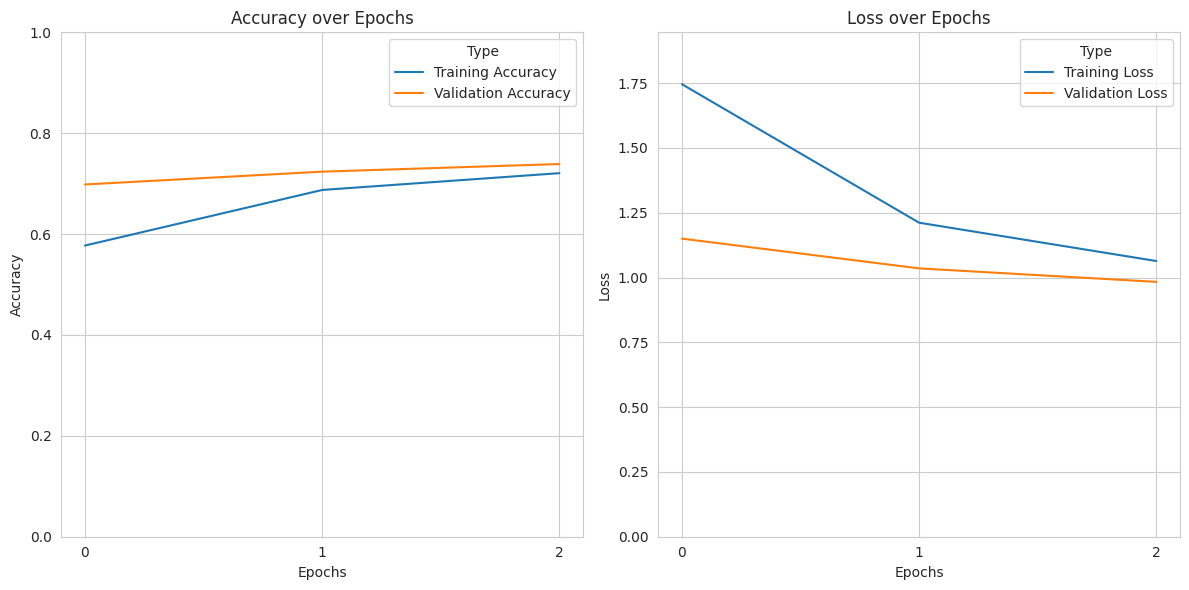

In [32]:
plot_loss_accuracy_curves(history)